# 2次元の円の面積を Monte Carlo で求める

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import scipy.special

%matplotlib inline
plt.rcParams['font.size'] = 14

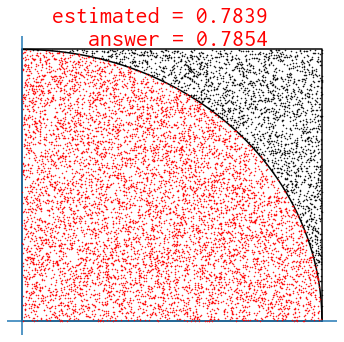

In [2]:
size = [2, 10**4]
x = np.random.uniform(size=size)
flags = (x**2).sum(axis=0) <= 1
area = flags.mean()

fig, ax = plt.subplots(figsize=[5, 5])

ax.set_axis_off()
theta = np.linspace(0, np.pi/2, 1000)
L = 1/np.sqrt(2)
M = (1 + L) / 2
ax.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], '-', c='k')
ax.plot(np.sin(theta), np.cos(theta), '-', c='k')
ax.axhline(0)
ax.axvline(0)

ax.plot(x[0, flags], x[1, flags], '.', c='r', markersize=1)
ax.plot(x[0, ~flags], x[1, ~flags], '.', c='k', markersize=1)

text = ax.text(0.1, 1,
               f"estimated = {area:.4f}\n   answer = {np.pi / 4:.4f}",
               c='r', ha='left', va='bottom', fontsize=24)

fig.tight_layout()
fig.savefig('./images/FoDS_4.3_MonteCarloSample.jpg')

# 超球面の体積(volume of unit ball)をMonte Carloで求める

## 単純Monte Carloの場合
d次元の単位超球面(unit ball)の体積は、Lemma 2.6 によると、
$$
V(d) = \frac{2 \pi^{\frac{d}{2}}}{d \Gamma(\frac{d}{2})}
$$

すべての次元の値が正(positive)の領域に限定すると、$\frac{1}{2^d}$倍になるから
$$
V_{+}(d) = \frac{\pi^{\frac{d}{2}}}{d \cdot 2^{d-1} \Gamma(\frac{d}{2})}
$$

In [3]:
# d次元の体積(すべての次元がpositiveとなる領域)
def volume_of_positive_unit_ball(d):
    return np.pi**(d/2) / (d * 2**(d-1) * scipy.special.gamma(d/2))

In [4]:
d_max = 20
d_vec = np.arange(d_max) + 1
volumes = volume_of_positive_unit_ball(d_vec)

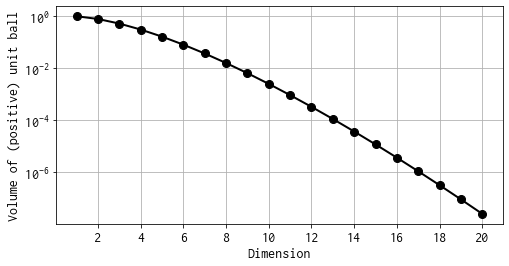

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(d_vec, volumes, 'o-', c='k', markersize=8, linewidth=2)
ax.set_xlabel('Dimension')
ax.set_ylabel('Volume of (positive) unit ball')
ax.set_yscale('log')
ax.set_xticks(range(2, 21, 2))
ax.grid(which='major')

fig.savefig('./images/FoDS_4.3_CubeVolume.jpg')

In [6]:
def unit_sphere_simple_mc(d, n_sample=100000):
    real_volume = volume_of_positive_unit_ball(d)
    samples = np.random.uniform(size=(n_sample, d))

    flags_in_sphare = (samples ** 2).sum(axis=1) <= 1
    area_estimated = np.cumsum(flags_in_sphare) / (np.arange(n_sample) + 1)
    ratio_vs_real_volume = area_estimated / real_volume
    return ratio_vs_real_volume

In [7]:
d_max, n_sample = 20, 100000

results = np.zeros((n_sample, d_max))
for d in np.arange(d_max) + 1:
    results[:, d-1] = unit_sphere_simple_mc(d, n_sample=n_sample)

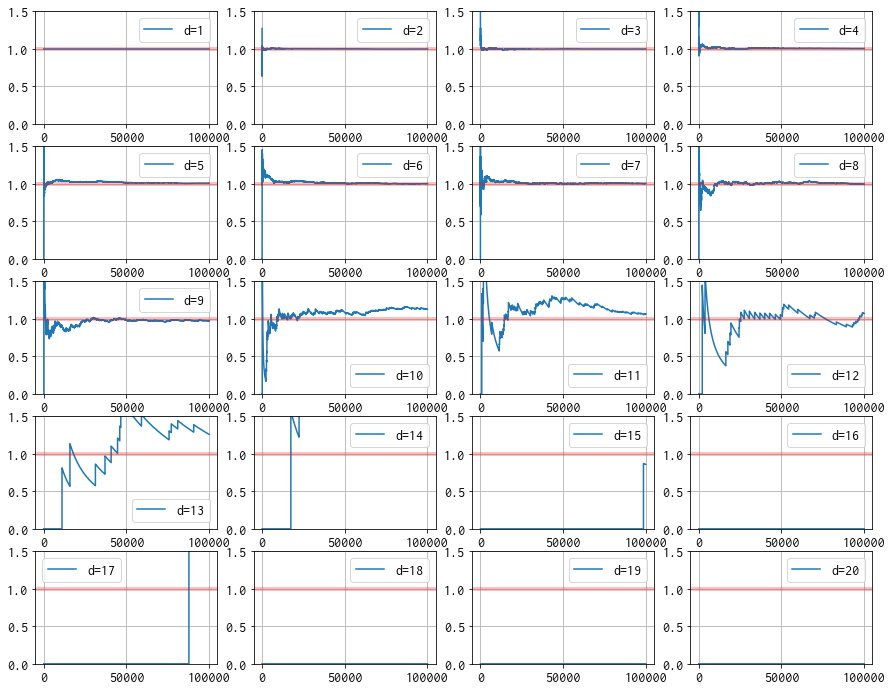

In [8]:
fig, axes = plt.subplots(5, 4, figsize=(15, 12))

x = np.arange(n_sample) + 1

for idx, ax in enumerate(axes.flatten()[:d_max]):
    d = idx + 1
    ax.plot(x, results[:, idx], '-', label=f'd={d}')
    ax.axhline(1.0, color='r', linewidth=4, alpha=0.25)
    ax.set_ylim([0, 1.5])
    ax.grid(which='major')
    ax.legend()

---
## Random Walk による体積推定のイメージ

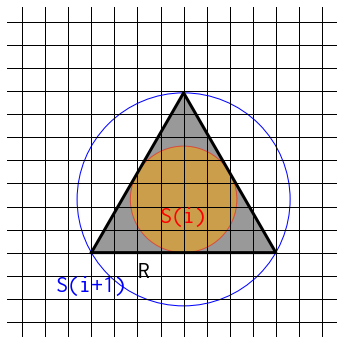

In [9]:
fig, ax = plt.subplots(figsize=[5, 5])
ax.set_axis_off()

for v in np.arange(0.15, 0.85, 0.05):
    ax.axhline(v, color='k', linewidth=1)
    ax.axvline(v, color='k', linewidth=1)

# 求めたい図形 R
yy = 0.3 + 0.2 * np.sqrt(3)
ax.plot([0.3, 0.7, 0.5, 0.3],
        [0.3, 0.3,  yy, 0.3], '-', c='k', linewidth=3)
ax.fill_between([0.3, 0.5, 0.7],
                [0.3, 0.3, 0.3],
                [0.3, yy, 0.3],
                facecolor='k', alpha=0.4)
ax.text(0.4, 0.28, "R", fontsize=24, color="k", va="top", ha="left")

theta = 2 * np.pi * np.linspace(0, 1, 1000)
x, y = np.sin(theta), np.cos(theta)

r0 = 0.2 * np.sqrt(1/3)
x0, y0, r = 0.5, 0.3 + r0, r0
circle_1 = patches.Circle((x0, y0), r, fc='orange', ec='r', alpha=0.5)
x0, y0, r = 0.5, 0.3 + r0, r0 * 2.
circle_2 = patches.Circle((x0, y0), r, ec='b', fill=False)
ax.add_patch(circle_1)
ax.add_patch(circle_2)
ax.text(0.3, 0.25, "S(i+1)", fontsize=24, color="b", va="top", ha="center")
ax.text(0.5, 0.4, "S(i)", fontsize=24, color="r", va="top", ha="center")

fig.tight_layout()
fig.savefig('./images/FoDS_4.3_Circle_with_Triangle.jpg')

---
## Random Walk による体積の推定
- テキストとは違って、徐々に大きくなる正方形(rectangle) による単位球の体積(volume of unit sphere)の推定を実施する

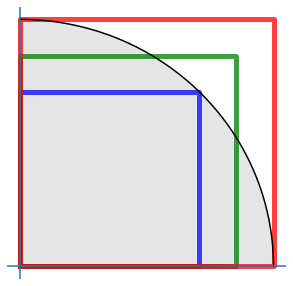

In [10]:
fig, ax = plt.subplots(figsize=[5, 5])

ax.set_axis_off()
theta = np.linspace(0, np.pi/2, 1000)
L = 1/np.sqrt(2)
M = (1 + L) / 2
ax.plot([0, L, L, 0, 0], [0, 0, L, L, 0], '-', c='b', linewidth=5, alpha=0.75)
ax.plot([0, M, M, 0, 0], [0, 0, M, M, 0], '-', c='g', linewidth=5, alpha=0.75)
ax.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], '-', c='r', linewidth=5, alpha=0.75)
ax.plot(np.sin(theta), np.cos(theta), '-', c='k')
ax.fill_between(np.sin(theta), np.cos(theta), 0, facecolor='k', alpha=0.1)
ax.axhline(0)
ax.axvline(0)

- すべての次元が正の単位球の体積を求めるために、次の手順を考える。
- この単位球に内接する最大の立方体(cube) (図の<font color='blue'>**緑**</font>)から徐々にサイズを大きくして、  
  この単位球に外接する最小の立方体(図の<font color='red'>**赤**</font>)まで大きくする
- 最小のcubeの1辺は $l = \frac{1}{\sqrt{d}}$
- 次に大きな cube は $1 + \frac{1}{d}$ 倍となるようにとる

In [11]:
def calc_k(d):
    return np.ceil(.5 * np.log(d) / np.log(1 + 1/d)).astype(int)

In [12]:
def random_walk_sampling(d, L_upper, L_lower, eps=0.025, n_sample=1000):
    start_pos = int(1 / np.sqrt(d) * 0.5 / eps) * eps

    vec = np.asarray([start_pos,] * d)
    prev = vec.copy()

    results = np.zeros(n_sample)
    
    for idx in range(n_sample):
        next_d = np.random.choice(d)
        vec[next_d] += eps if np.random.uniform() < .5 else -eps
        if np.any(vec < 0) or np.any(L_upper <= vec) or 1 < vec.dot(vec):
            vec[:] = prev
        
        if np.all(vec <= L_lower):
            results[idx] += 1
        
        prev[:] = vec
    
    return (np.arange(n_sample) + 1) / np.cumsum(results)

In [13]:
d = 15
L_min = 1 / np.sqrt(d)
k_max = calc_k(d)
Ls = [L_min * (1 + 1/d) ** k for k in np.arange(k_max + 1)]
V_min = L_min ** d

In [14]:
ratios = []
rejection_rates = []

for k in np.arange(1, k_max + 1):
    print(f'k={k}')
    ratio = random_walk_sampling(d, Ls[k], Ls[k-1], eps=0.02, n_sample=50000)
    ratios.append(ratio)

k=1
k=2
k=3
k=4
k=5
k=6
k=7
k=8
k=9
k=10
k=11
k=12
k=13
k=14
k=15
k=16
k=17
k=18
k=19
k=20
k=21


In [15]:
V = np.vstack(ratios).prod(axis=0) * V_min

In [16]:
V_real = volume_of_positive_unit_ball(d)

In [17]:
V / V_real

array([1.29818182e-04, 1.29818182e-04, 1.29818182e-04, ...,
       1.79231525e+00, 1.79243866e+00, 1.79256207e+00])

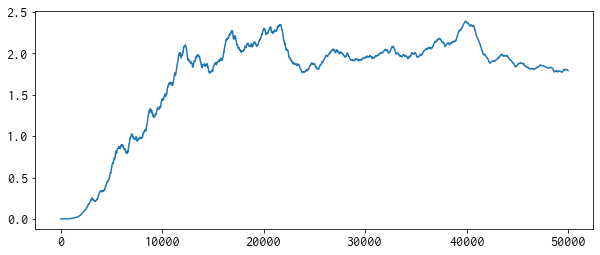

In [18]:
fig, ax = plt.subplots(figsize=[10, 4])

ax.plot(V / V_real)